## Loading and preparing JSON data

We load jsons and save for each classified window. We'll save a big file with subject name, frame, confidence and
joint id; And later we'll add subject class and frame class. Where subject class is overall normal or abnormal, 
and frame class is tagged as if used for study (GM).

In [9]:
import json
import os
import pandas as pd


data = []
data_folder = 'D:/babybrain/confidences/'
data_files = sorted(os.listdir(data_folder))
for a_file in data_files:
    with open(data_folder + a_file) as json_file:
        single_data = json.load(json_file)
        my_frames = single_data['processed_frames']
        my_confidences = single_data['confidences']
        for frame_value, confidence_value in zip(my_frames, my_confidences):
            for index, a_confidence in enumerate(confidence_value):
                data.append([a_file[:-5], frame_value, a_confidence, index])

# create a DataFrame
columns = ['subject', 'frame', 'confidence', 'joint_id'] 
df = pd.DataFrame(data, columns=columns)

# save it as csv
df.to_csv('D:/babybrain/confidences.csv')

## Loading label data

We load the excel files with specialist classification, we'll add to prior data two 
columns containing subject class (1=normal, 0=abnormal) and frame class (1 is used as
General Movement and 0 if its not used as subject classification)

In [12]:
import pandas as pd


# a small function to check if a frame time is inside a tag stamp
def in_window(frame_sec, time_start, time_end, fps=240):
    return time_start.second + 60*time_start.minute <= frame_sec/fps <= time_end.second + 60*time_end.minute


# first we import from label files
label_path = 'D:/babybrain/SubjectTags.xlsx'
labels = pd.read_excel(label_path, engine='xlrd')

names = labels['Sujeto']
tag = labels['Normal']
# times are in date.time format
start = labels['T0']
end = labels['T1']

# now we import the processed data to add the columns
input_path = 'D:/babybrain/confidences.csv'
inputs = pd.read_csv(input_path)

# for each value in inputs we find the subject and check if frame inside a classification
input_names = inputs['subject']
frames = inputs['frame']
is_gm = []
is_normal = []
for index, an_input in enumerate(input_names):
    # search for subject index in the label data and then get all his intervals
    interval_indexes = [i for i, label in names.iteritems() if an_input == int(label)]
    # for each interval we check frame time is inside a label window
    if any([in_window(frames[index], start[subindex], end[subindex]) for subindex in interval_indexes]):
        is_gm.append(1)
        # we can append any of the intervals tag as normal or abnormal, its the same for all
        is_normal.append(int(tag[interval_indexes[0]]))
    else:
        is_gm.append(0)
        is_normal.append(-1)
    
# save new columns into Data Frame
inputs['is_gm'] = is_gm
inputs['is_normal'] = is_normal
inputs.to_csv(input_path)

## Using new labels and data exploration
We make an average value of joint confidence per class to check if at clear eye we
can tell a difference in values, even if we can't we can use effectively a random
forest classifier.

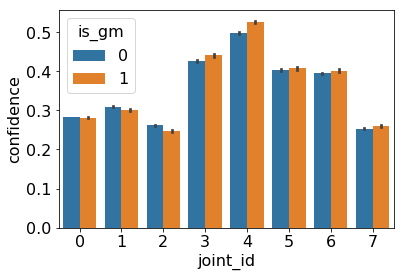

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get the data frame
input_path = 'D:/babybrain/confidences.csv'
data = pd.read_csv(input_path)

# create a simple graph with seaborn
graph = sns.barplot(x='joint_id', y='confidence', hue='is_gm', data=data)
plt.show()

## Training Random Forest Classifier
Now we use data to train a random forest classifier for either GM or normal. To separate data into
a train and test set we make sure one subject is not inside both sets.

abnormal ratio of data is 0.49408478475188955
Recall Baseline: 1.0 Test: 0.7 Train: 1.0
Precision Baseline: 0.51 Test: 0.78 Train: 1.0
Roc Baseline: 0.5 Test: 0.82 Train: 1.0


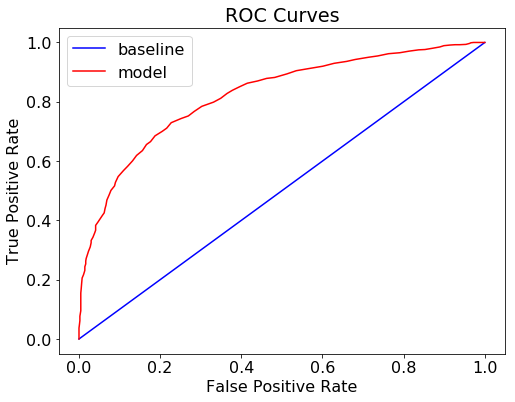

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from qol import evaluate_model
import pickle
import json


# get the data frame
input_path = 'D:/babybrain/confidences.csv'
data = pd.read_csv(input_path)

# prepare the data to fit in the model, we need to compress the confidences into a vector
classifying = 'is_normal'
label = data[classifying].tolist()
confidences = data['confidence'].tolist()
joint_id = data['joint_id'].tolist()
names = data['subject'].tolist()

X = []
y = []
subject = []

step = max(joint_id) + 1
for index in range(0, len(label), step+1):
    # this is how we mark trash data if it has NaN or None
    if label[index] < 0 or np.any(np.isnan(confidences[index:index+step])) or len(confidences[index:index+step])!=step:
        continue
    X.append(confidences[index:index+step])
    y.append(label[index])
    subject.append(names[index])
# save as numpy arrays to mask them later
X = np.array(X)
y = np.array(y)

# check how balanced is the database
print("abnormal ratio of data is {}".format(1 - (sum(y)/len(y))))

# before splitting the data we group by subject, because we don't want the same subject inside the 
# train-test group
last_label = y[0]
grouped_indexes = []
index_container = []
grouped_labels = []
last_index = None
for index, _ in enumerate(y):
    index_container.append(index)
    last_index = index
    if not last_label == y[index]:  # reset the container and stored subject
        grouped_labels.append(last_label)
        last_label = y[index]
        grouped_indexes.append(index_container)
        index_container = []
grouped_indexes.append(index_container)  # appending the last container
grouped_labels.append(last_label)

# split the grouped indexes to get the train test groups
train_group, test_group, _, _ = train_test_split(grouped_indexes, grouped_indexes, test_size=0.3, 
                                                 stratify=grouped_labels)
# or we can split without caring about same subject in both sets

# we take each group and flatten it and use it as mask to extract the real data
train_mask = [an_index for a_list in train_group for an_index in a_list]
test_mask = [an_index for a_list in test_group for an_index in a_list]

# split data
train = X[train_mask]
train_labels = y[train_mask]
test = X[test_mask]
test_labels = y[test_mask]

# or we can just use the simple way of separating data without caring about sane subject in two sets
# uncomment if you're brave enough
train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.3, stratify=y)
# as a debug ill save train in a file
pd.DataFrame(data=train).to_csv('test.csv')

# create the model with many many trees
model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt')

# fit on training data
model.fit(train, train_labels)

# calculate ROC for model
train_prediction = model.predict(train)
train_prob = model.predict_proba(train)
train_prob = train_prob[:, 1]

prediction = model.predict(test)
prob = model.predict_proba(test)
prob = prob[:, 1]

evaluate_model(prediction, prob, train_prediction, train_prob, train_labels, test_labels,
               output='model_roc.png')

# we save model with pickle, if this works badly we can use joblib too
model_out = 'classification_model.pkl'
pickle.dump(model, open(model_out, 'wb'))

# we also save used data just in case we want to keep doing some analysis
used_data = dict(train=train.tolist(), train_labels=train_labels.tolist(), 
                 test=test.tolist(), test_labels=test_labels.tolist())
with open('classification_data.json', 'w') as f:
    json.dump(used_data, f)

## Exploring discrete to windows classification

We need to transform discrete results into windowed results, we'll check how much variability
is in a window so we can use this parameter for future results

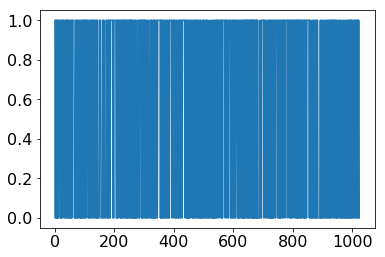

In [7]:
import pickle
import json
import matplotlib.pyplot as plt


# TODO: I can't make this work because I need to sort them by index first
# load model
model_path = 'D:/Projects/mybabybrain-model/classification_model.pkl'
model = pickle.load(open(model_path, 'rb'))

# load data
data_path = 'D:/Projects/mybabybrain-model/classification_data.json'
data = json.load(open(data_path, 'rb'))

# just to watch the data we'll plot the test labels as a timeline to see how it variates
test_labels = data['test_labels']
plt.plot(range(len(test_labels)), test_labels)


## Using the classifier with "Winner Takes All"

We have the trained model and it works well yay, now we need to translate the results into time windows classified
as General Movements or Normal/Abnormal state.

In [5]:
import pickle
import json
import numpy as np


# model and used data
class_model = pickle.load(open('D:/babybrain/classification_model_gm.pkl', 'rb'))

# lets use a test subject
test_path = 'D:/babybrain/confidences/003745.json'
subject_data = json.load(open(test_path, 'rb'))
confidence_list = subject_data['confidences']
frame_list = subject_data['processed_frames']

# we need a variability function to transform discrete results into windows, for now we just use
# set windows of 10 seconds as our windows
window_size_seconds = 10
fps = 240
fskip = 30
window_size_data = int(window_size_seconds*fps/fskip)  # at 240fps and 30 fskip we have 8 data per second

# calculate predictions
# first we remove possible nans from data
confidence_list = [a_sample for a_sample in confidence_list if not np.any(np.isnan(a_sample))]
predictions = class_model.predict(confidence_list)

# compress into abnormal windows
# we will store the windows into a simple format t0, t1 for desired windows
compressed_windows = []
for index in range(0, len(predictions), window_size_data):
    sub_sample = predictions[index:index+window_size_data-1]
    score = np.nanmean(sub_sample)
    if score < 0.5:  # then we have an abnormal case
        t0 = frame_list[index]/fps
        t1 = frame_list[index]/fps + window_size_seconds
        compressed_windows.append([t0, t1])

# now we extend windows they're next to each other
compressed_windows_extended = []
stored_t0 = None
stored_t1 = None
if compressed_windows:
    stored_t0, stored_t1 = compressed_windows[0]

for index, (t0, t1) in enumerate(compressed_windows):
    # we store the values if not connected to next window or last window
    if stored_t1 - t0 > window_size_seconds or index == len(compressed_windows)-1:
        compressed_windows_extended.append([stored_t0, stored_t1])
        stored_t0 = t0
    else:  # we keep compressing windows
        stored_t1 = t1

if compressed_windows_extended:
    print("average subject score is {}".format(np.nanmean(predictions)))
else:
    print("there was no classification window for this subject (may be scarily accurate)")

average subject score is 0.2623664424218441
